In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import SKDS

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

SKDS created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.544098
epoch: 0, lr: 0.01
train loss: 22982.265190972223, val loss: 14582.9009765625
train sk metric: 0, val sk metric: 0
learning time: 0:00:05.684421
epoch: 10, lr: 0.0025
train loss: 439.57954463252315, val loss: 383.9063781738281
train sk metric: 0, val sk metric: 0
test loss: 459.4569946289063
learning time: 0:00:10.504625
test sklearn metric: 
0 



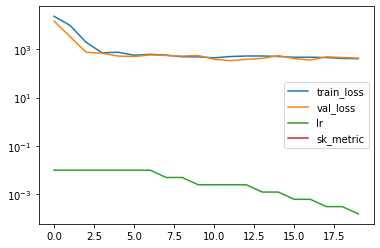

In [3]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'embed': [],
                              'make': 'make_regression',
                              'transform': None,
                              'target_transform': None,
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=20)

CModel loaded...
FFNet model loaded...
learning time: 0:00:00.904152
epoch: 0, lr: 0.01
train loss: 1537.897731477535, val loss: 1525.2370571010688
train sk metric: 0, val sk metric: 0
learning time: 0:00:08.267669
epoch: 10, lr: 0.01
train loss: 89.29911416106754, val loss: 123.02778524160385
train sk metric: 0, val sk metric: 0
learning time: 0:00:15.737494
epoch: 20, lr: 0.01
train loss: 30.962499505943722, val loss: 31.174787163734436
train sk metric: 0, val sk metric: 0
learning time: 0:00:23.125051
epoch: 30, lr: 0.01
train loss: 30.31251084142261, val loss: 32.85796231031418
train sk metric: 0, val sk metric: 0
learning time: 0:00:30.546437
epoch: 40, lr: 0.01
train loss: 29.188015672895645, val loss: 29.369328260421753
train sk metric: 0, val sk metric: 0
test loss: 32.316944897174835
learning time: 0:00:37.444360
test sklearn metric: 
0 



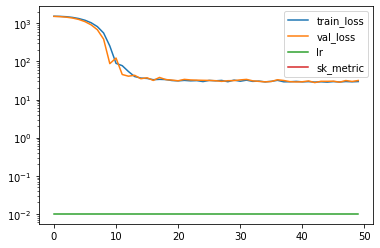

In [5]:
model_params = {'D_in': 23*23+23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['distance','coulomb'],
                              'targets': ['ae'],
                              'embed': [('atoms',7,32,0,True)],
                              'in_file': './data/qm7/qm7.mat'}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 5}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=512, epochs=50)

CModel loaded...
FFNet model loaded...
learning time: 0:00:00.551544
epoch: 0, lr: 0.01
train loss: 1566.9036044163818, val loss: 1558.13309999177
train sk metric: 0, val sk metric: 0
learning time: 0:00:05.442645
epoch: 10, lr: 0.01
train loss: 740.9146492282549, val loss: 628.0450464189053
train sk metric: 0, val sk metric: 0
learning time: 0:00:10.328513
epoch: 20, lr: 0.01
train loss: 50.81469938490126, val loss: 59.15958973765373
train sk metric: 0, val sk metric: 0
learning time: 0:00:15.329318
epoch: 30, lr: 0.01
train loss: 43.98495489358902, val loss: 53.69572523236275
train sk metric: 0, val sk metric: 0
learning time: 0:00:20.216277
epoch: 40, lr: 0.01
train loss: 40.860274109575485, val loss: 52.853694796562195
train sk metric: 0, val sk metric: 0
test loss: 52.43608957529068
learning time: 0:00:24.963648
test sklearn metric: 
0 



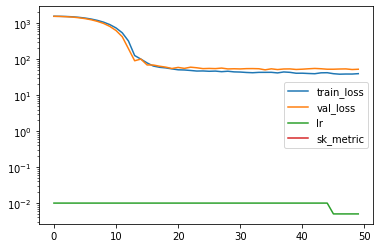

In [7]:
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'embed': []}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 5}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=512, epochs=50)

In [11]:
#find the longest molecule

ds_params = {'ds_params': {'features': ['distance'],
                           'pad': 23,
                           'targets': ['eAT'],
                           'embed': [('atNUM',9,64,0,True)],
                           'selector': ['opt'],
                           'use_h5': True}}

qm7x = QM7X(**ds_params['ds_params'])
l = 0
for i in qm7x.ds_idx:
    s = qm7x[i][0].shape.numel()
    if s > l:
        l = s
print(l)

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
529


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.041080
epoch: 0, lr: 0.01
train loss: 66.15129851514895, val loss: 44.64863457819456
train sk metric: 0, val sk metric: 0
test loss: 2.4298102279448512
learning time: 0:00:08.574562
test sklearn metric: 
0 



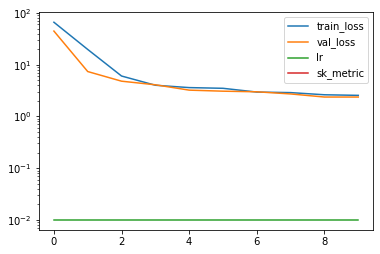

In [8]:
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['distance'],
                              'pad': 23,
                              'targets': ['eAT'],
                              'embed': [('atNUM',9,64,0,True)],
                              'selector': ['opt'],
                              'use_h5': False}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 5}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=10)

In [ ]:
model_params = {'D_in': 12*12+12*12+12*12*16, 
                'H': 4096, 
                'D_out': 12, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'n': 133885, 
                              'features': ['distance','coulomb'],
                              'embed': [('adjacency',4,16,0,True)], 
                              'targets': ['mulliken'],
                              'pad': 12, 
                              'filter_on': ('n_atoms','<','13'),
                              'use_pickle': 'n_atoms_less_than_13.p'}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=10)

In [ ]:
model_params = {'D_in': 29*29+29*29+29*29*8, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'n': 133885, 
                              'features': ['distance','coulomb'],
                              'embed': [('adjacency',4,8,0,True)],
                              'targets': ['U0'],
                              'pad': 29, 
                              'filter_on': False,
                              'use_pickle': 'qm9.p'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=32, epochs=20)

In [ ]:
model_params = {'D_in': 64*63+63*63, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embed': [('atomic_numbers',6,64,0,True)],
                              'pad': 63, #length of the longest molecule in the dataset
                              'criterion': 'wb97x_dz.energy',
                              'conformation': 'min',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=100)